Added dropout (20% in the newsencoder - did not improve when adding to the user encoder).

New word embeddings (Danish): https://loar.kb.dk/items/33396585-6918-4cf0-8f76-723594766f37

Smaller batch size (16)

In [1]:
import numpy as np
import pandas as pd
import random
from google.colab import drive
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def encode_timestamp(timestamp):
    dt = pd.to_datetime(timestamp)

    # Cyclic encoding
    sin_hour = np.sin(2 * np.pi * dt.hour / 24)
    cos_hour = np.cos(2 * np.pi * dt.hour / 24)

    # Continuous and one-hot features
    month_one_hot = np.eye(12)[dt.month - 1]  # One-hot encode month
    weekday_one_hot = np.eye(7)[dt.weekday()] # One-hot encode weekday

    # Combine features
    return np.concatenate([month_one_hot, weekday_one_hot, [sin_hour, cos_hour]])

In [5]:
MAX_TITLE_LEN = 20

articles_path = '/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/articles.parquet'
behaviors_train_path = '/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/behaviors_train.parquet'
behaviors_val_path = '/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/behaviors_val.parquet'
history_train_path = '/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/history_train.parquet'
history_val_path = '/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/history_val.parquet'

# Load data from Parquet files
articles = pd.read_parquet(articles_path)
train_behaviors = pd.read_parquet(behaviors_train_path)
val_behaviors = pd.read_parquet(behaviors_val_path)
history_train = pd.read_parquet(history_train_path)
history_val = pd.read_parquet(history_val_path)

# Create a news dict and  article_id to a unique index
news = {}
newsindex = {'NULL': 0}  # Add a NULL key for padding
for idx, row in articles.iterrows():
    article_id = row['article_id']
    title = row['title'].lower()
    tokenized_title = word_tokenize(title)

    news[article_id] = tokenized_title
    newsindex[article_id] = len(newsindex)

# Summary
print("Number of unique articles:", len(news))
print("Example article ID and tokenized title:")
for k, v in list(news.items())[:3]:  # Print first 3 articles
    print(f"Article ID: {k}, Tokenized Title: {v}")

print("\nTotal articles indexed in newsindex:", len(newsindex), "\n")


# Helper function to sample negative examples
def newsample(array, ratio):
    if len(array) == 0:
        return []
    if ratio > len(array):
        return random.sample(array * (ratio // len(array) + 1), ratio)
    else:
        return random.sample(array, ratio)

# Sampling configuration
npratio = 4  # Number of negative samples per positive sample
MAX_HISTORY_LEN = 50

# Function to process behaviors data
def process_behaviors(behaviors, newsindex, history_data=None):
    train_candidate = []
    train_label = []
    train_user_his = []
    candidate_timestamps = []
    user_his_timestamps = []

    # Build a user history dictionary from history data if provided
    user_history = {}
    user_history_time = {}
    if history_data is not None:
        for _, row in history_data.iterrows():
            user_history[row['user_id']] = [newsindex.get(aid, 0) for aid in row['article_id_fixed']]
            user_history_time[row['user_id']] = [encode_timestamp(ts) for ts in row['impression_time_fixed']]

    for _, row in behaviors.iterrows():
        user_id = row['user_id']

        # Clicked articles (positive examples)
        clicked = [newsindex.get(aid, 0) for aid in row['article_ids_clicked'] if aid in newsindex]
        clicked_times = [encode_timestamp(row['impression_time'])] * len(clicked)

        # Non-clicked articles (negative examples)
        inview = set(row['article_ids_inview'])
        non_clicked = [newsindex.get(aid, 0) for aid in inview if aid in newsindex and aid not in row['article_ids_clicked']]
        non_clicked_times = [encode_timestamp(row['impression_time'])] * len(non_clicked)

        # User history
        if user_id in user_history:
            clickids = user_history[user_id][-MAX_HISTORY_LEN:]
            click_times = user_history_time[user_id][-MAX_HISTORY_LEN:]
        else:
            clickids = clicked[-MAX_HISTORY_LEN:]
            click_times = clicked_times[-MAX_HISTORY_LEN:]

        for pos_doc, pos_time in zip(clicked, clicked_times):
            neg_docs = newsample(non_clicked, npratio)
            neg_times = newsample(non_clicked_times, npratio)

            candidates = neg_docs + [pos_doc]
            times = neg_times + [pos_time]

            labels = [0] * npratio + [1]

            # Shuffle candidates and labels
            shuffle_indices = list(range(len(candidates)))
            random.shuffle(shuffle_indices)
            shuffled_candidates = [candidates[i] for i in shuffle_indices]
            shuffled_times = [times[i] for i in shuffle_indices]
            shuffled_labels = [labels[i] for i in shuffle_indices]

            # Append training data
            train_candidate.append(shuffled_candidates)
            candidate_timestamps.append(shuffled_times)
            train_label.append(shuffled_labels)
            train_user_his.append(clickids + [0] * (MAX_HISTORY_LEN - len(clickids)))
            user_his_timestamps.append(click_times + [[0] * 21] * (MAX_HISTORY_LEN - len(click_times)))

    return train_candidate, train_label, train_user_his, candidate_timestamps, user_his_timestamps

# Process train behaviors
train_candidate, train_label, train_user_his, train_candidate_timestamps, train_user_his_timestamps = \
process_behaviors(train_behaviors, newsindex, history_train)
val_candidate, val_label, val_user_his, val_candidate_timestamps, val_user_his_timestamps = \
    process_behaviors(val_behaviors, newsindex, history_val)

""" # Process validation behaviors
val_candidate, val_user_his, val_labels, val_index = [], [], [], []
for _, row in val_behaviors.iterrows():
    user_id = row['user_id']
    clicked = [newsindex.get(aid, 0) for aid in row['article_ids_clicked'] if aid in newsindex]
    #inview = set(row['article_ids_inview'])
    #non_clicked = [newsindex.get(aid, 0) for aid in inview if aid in newsindex and aid not in row['article_ids_clicked']]

    user_history = clicked[-MAX_HISTORY_LEN:]
    user_history = user_history + [0] * (MAX_HISTORY_LEN - len(user_history))


    start_idx = len(val_candidate)

    for aid in row['article_ids_inview']:
        if aid in newsindex:
            val_candidate.append(newsindex[aid])
            val_user_his.append(user_history)
            val_labels.append(1 if aid in row['article_ids_clicked'] else 0)

    end_idx = len(val_candidate)
    val_index.append([start_idx, end_idx]) """

# Print summary
print("Training Data:")
print("Number of training candidates:", len(train_candidate))
print("Number of training labels:", len(train_label))
print("Number of user histories:", len(train_user_his))
print("Number of candidate timestamps:", len(train_candidate_timestamps))
print("Number of user history timestamps:", len(train_user_his_timestamps))

print("\nValidation Data:")
print("Number of validation candidates:", len(val_candidate))
print("Number of validation labels:", len(val_label))
print("Number of user histories:", len(val_user_his))
print("Number of candidate timestamps:", len(val_candidate_timestamps))
print("Number of user history timestamps:", len(val_user_his_timestamps))


Number of unique articles: 11777
Example article ID and tokenized title:
Article ID: 3037230, Tokenized Title: ['ishockey-spiller', ':', 'jeg', 'troede', 'jeg', 'skulle', 'dø']
Article ID: 3044020, Tokenized Title: ['prins', 'harry', 'tvunget', 'til', 'dna-test']
Article ID: 3057622, Tokenized Title: ['rådden', 'kørsel', 'på', 'blå', 'plader']

Total articles indexed in newsindex: 11778 

Training Data:
Number of training candidates: 24888
Number of training labels: 24888
Number of user histories: 24888
Number of candidate timestamps: 24888
Number of user history timestamps: 24888

Validation Data:
Number of validation candidates: 25505
Number of validation labels: 25505
Number of user histories: 25505
Number of candidate timestamps: 25505
Number of user history timestamps: 25505


In [6]:
# Save Train Data
train_df = pd.DataFrame({
    'candidate': train_candidate,
    'label': train_label,
    'user_his': train_user_his
})
train_df.to_parquet('/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/train_data.parquet', index=False)

# Save Validation Data
val_df = pd.DataFrame({
    'candidate': val_candidate,
    'label': val_label,
    'user_his': val_user_his
})
val_df.to_parquet('/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/val_data.parquet', index=False)

# Print Confirmation
print("Train and Validation data saved as Parquet files:")
print("  - train_data.parquet")
print("  - val_data.parquet")


Train and Validation data saved as Parquet files:
  - train_data.parquet
  - val_data.parquet


In [7]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

# Build vocabulary from tokenized titles
vocab = {'<PAD>': 0}  # Start with a padding token
for tokens in news.values():
    for word in tokens:
        if word not in vocab:
            vocab[word] = len(vocab)

# Convert titles to token indices
news_tensor = {}
for article_id, tokens in news.items():
    token_indices = [vocab[word] for word in tokens]  # Convert words to token indices

    # Truncate or pad to MAX_TITLE_LEN
    if len(token_indices) > MAX_TITLE_LEN:
        token_indices = token_indices[:MAX_TITLE_LEN]  # Truncate if too long
    else:
        token_indices += [0] * (MAX_TITLE_LEN - len(token_indices))  # Pad with zeros

    news_tensor[newsindex[article_id]] = torch.tensor(token_indices, dtype=torch.long)
    news_tensor[0] = torch.zeros(MAX_TITLE_LEN, dtype=torch.long)

news_tensors_list = [tensor[:MAX_TITLE_LEN] for tensor in news_tensor.values()]  # Truncate to MAX_TITLE_LEN
news_tensors_padded = pad_sequence(news_tensors_list, batch_first=True, padding_value=vocab['<PAD>'])

# Example Output
print("Vocabulary size:", len(vocab))
print("Shape of padded news tensors:", news_tensors_padded.shape)

Vocabulary size: 16003
Shape of padded news tensors: torch.Size([11778, 20])


In [8]:
import numpy as np
def load_glove_embeddings(file_path, embedding_dim):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            embedding = np.array(values[1:], dtype='float32')
            embeddings_index[word] = embedding
    print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")
    return embeddings_index

# Load GloVe embeddings (300d)
glove_embeddings = '/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/danish_newspapers_1880To2013.txt'
embedding_dim = 300
glove_index = load_glove_embeddings(glove_embeddings, embedding_dim)

Loaded 2404837 word vectors from GloVe.


In [9]:
import torch
import torch.nn as nn
import numpy as np

def create_embedding_matrix(vocab, glove_index, embedding_dim):
    """
    Create an embedding matrix for a given vocabulary using GloVe embeddings.

    Args:
        vocab (dict): Vocabulary mapping words to indices.
        glove_index (dict): GloVe embeddings loaded from the file.
        embedding_dim (int): Dimension of the embeddings.

    Returns:
        torch.Tensor: The embedding matrix.
        int: Count of OOV words.
        int: Count of IV words.
    """
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Initialize with zeros

    for word, idx in vocab.items():
        if word in glove_index:  # Use GloVe embedding if available
            embedding_matrix[idx] = glove_index[word]
        else:  # Random initialization for words not in GloVe
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return torch.tensor(embedding_matrix, dtype=torch.float32)

# Create the embedding matrix
embedding_matrix = create_embedding_matrix(vocab, glove_index, embedding_dim)

In [10]:
# Vocabulary analysis
total_vocab_size = len(vocab)
iv_count = len([word for word in vocab if word in glove_index])
oov_count = total_vocab_size - iv_count

iv_percentage = (iv_count / total_vocab_size) * 100
oov_percentage = (oov_count / total_vocab_size) * 100

print(f"Vocabulary size: {total_vocab_size}")
print(f"In-Vocabulary words: {iv_count} ({iv_percentage:.2f}%)")
print(f"Out-of-Vocabulary words: {oov_count} ({oov_percentage:.2f}%)")

# Sample OOV words
oov_words = [word for word in vocab if word not in glove_index]
print("Sample OOV words:", oov_words[:10])

Vocabulary size: 16003
In-Vocabulary words: 12290 (76.80%)
Out-of-Vocabulary words: 3713 (23.20%)
Sample OOV words: ['<PAD>', 'ishockey-spiller', ':', 'dna-test', 'mærsk-arvinger', 'zoo-tårnet', '100', 'creamy-pige', '-', 'champagne-drengen']


In [11]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
    def __init__(self, data, news_tensor, candidate_times, user_his_times, max_history_len=50):
        """
        Args:
            data (pd.DataFrame): DataFrame with 'candidate', 'label', and 'user_his'
            news_tensor (dict): Dictionary mapping article_id to tokenized title tensors
            candidate_times (list): List of time features for candidate articles
            user_his_times (list): List of time features for user history
            max_history_len (int): Maximum length of user history
        """
        self.data = data
        self.news_tensor = news_tensor
        self.candidate_times = candidate_times
        self.user_his_times = user_his_times
        self.max_history_len = max_history_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Candidate titles: List of tokenized article titles (positive + negatives)
        candidate_ids = row['candidate']
        candidate_titles = torch.stack([self.news_tensor[aid] for aid in candidate_ids])
        candidate_times = torch.tensor(self.candidate_times[idx], dtype=torch.float32)

        # Labels: Positive (1) and negative (0) labels for candidates
        labels = torch.tensor(row['label'], dtype=torch.float)

        # User history: List of clicked articles converted to tokenized titles
        user_his_ids = row['user_his']
        user_his_titles = torch.stack([self.news_tensor[aid] for aid in user_his_ids])
        user_his_times = torch.tensor(self.user_his_times[idx], dtype=torch.float32)

        # Pad user history if it's shorter than max length
        if len(user_his_titles) < self.max_history_len:
            padding = torch.zeros((self.max_history_len - len(user_his_titles), candidate_titles.shape[1]), dtype=torch.long)
            user_his_titles = torch.cat((user_his_titles, padding), dim=0)

        # Pad user history times if shorter than max length
        if len(user_his_times) < self.max_history_len:
            time_padding = torch.zeros((self.max_history_len - len(user_his_times), user_his_times.shape[1]), dtype=torch.float32)
            user_his_times = torch.cat((user_his_times, time_padding), dim=0)

        return candidate_titles, candidate_times, user_his_titles, user_his_times, labels

In [13]:
from torch.utils.data import DataLoader

# Load train and validation data
train_data = pd.read_parquet('/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/train_data.parquet')
val_data = pd.read_parquet('/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/val_data.parquet')

# Initialize the Dataset for train and validation
train_dataset = NewsDataset(train_data, news_tensor, train_candidate_timestamps, train_user_his_timestamps, max_history_len=50)
val_dataset = NewsDataset(val_data, news_tensor, val_candidate_timestamps, val_user_his_timestamps, max_history_len=50)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Fetch a batch to test
for candidate_titles, candidate_times, user_his_titles, user_his_times, labels in train_loader:
    print("Candidate Titles Shape:", candidate_titles.shape)  # (batch_size, num_candidates, MAX_TITLE_LEN)
    print("Candidate Times Shape:", candidate_times.shape)    # (batch_size, num_candidates, time_feature_dim)
    print("User History Titles Shape:", user_his_titles.shape)  # (batch_size, max_history_len, MAX_TITLE_LEN)
    print("User History Times Shape:", user_his_times.shape)    # (batch_size, max_history_len, time_feature_dim)
    print("Labels Shape:", labels.shape)                      # (batch_size, num_candidates)
    break

Candidate Titles Shape: torch.Size([16, 5, 20])
Candidate Times Shape: torch.Size([16, 5, 21])
User History Titles Shape: torch.Size([16, 50, 20])
User History Times Shape: torch.Size([16, 50, 21])
Labels Shape: torch.Size([16, 5])


<ipython-input-11-f7a026092ac2>:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  candidate_times = torch.tensor(self.candidate_times[idx], dtype=torch.float32)


In [14]:
class NewsEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim=300, num_heads=20, attention_hidden_dim=200,
                 pretrained_embeddings=None, time_embedding_dim=21, dropout_prob=0.2):
        """
        Args:
            vocab_size (int): Size of the vocabulary
            embedding_dim (int): Dimension of word embeddings
            time_embedding_dim (int): Dimension of time embeddings
            pretrained_embeddings (torch.Tensor): Pre-trained embedding matrix
            dropout_prob (float): Dropout probability
        """
        super(NewsEncoder, self).__init__()

        # Word Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            self.embedding.weight.requires_grad = True

        # Linear Transformation for Time Embeddings
        self.time_fc = nn.Linear(time_embedding_dim, embedding_dim)

        # Dropout Layer
        self.dropout = nn.Dropout(p=dropout_prob)

        # Multi-Head Self-Attention
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, batch_first=True)

        # Additive Attention Network
        self.additive_attention_query = nn.Parameter(torch.randn(attention_hidden_dim))  # Query vector
        self.additive_attention_fc1 = nn.Linear(embedding_dim, attention_hidden_dim)
        self.additive_attention_fc2 = nn.Linear(attention_hidden_dim, 1)

        # Linear Layer to output fixed-size vector
        self.fc = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, title_tokens, time_features):
        """
        Args:
            title_tokens (Tensor): Shape (batch_size, max_title_len)
                                   - Tokenized and padded title tensors
            time_features (Tensor): Shape (batch_size, time_embedding_dim)
                                   - Encoded time features for the articles
        Returns:
            Tensor: Fixed-size vector representing the article (batch_size, embedding_dim)
        """
        # Step 1: Word Embedding
        embedded = self.embedding(title_tokens)  # Shape: (batch_size, max_title_len, embedding_dim)
        embedded = self.dropout(embedded)        # Apply dropout to embeddings

        # Step 2: Time Embedding
        time_embedded = self.time_fc(time_features)  # Shape: (batch_size, embedding_dim)
        time_embedded = time_embedded.unsqueeze(1).repeat(1, embedded.size(1), 1)  # Align with title_tokens

        # Combine Word and Time Embeddings
        combined_embedded = embedded + time_embedded  # Shape: (batch_size, max_title_len, embedding_dim)

        # Step 3: Multi-Head Self-Attention
        attn_output, _ = self.multihead_attention(combined_embedded, combined_embedded, combined_embedded)  # Shape: (batch_size, max_title_len, embedding_dim)
        attn_output = self.dropout(attn_output)  # Apply dropout to attention outputs

        # Step 4: Additive Attention
        additive_weights = torch.tanh(self.additive_attention_fc1(attn_output))  # Shape: (batch_size, max_title_len, attention_hidden_dim)
        additive_scores = self.additive_attention_fc2(additive_weights).squeeze(-1)  # Shape: (batch_size, max_title_len)

        # Compute attention weights (softmax over words)
        attention_weights = torch.softmax(additive_scores, dim=1)  # Shape: (batch_size, max_title_len)

        # Weighted sum of the attention outputs
        weighted_sum = torch.sum(attn_output * attention_weights.unsqueeze(-1), dim=1)  # Shape: (batch_size, embedding_dim)

        # Step 5: Linear Transformation
        output_vector = self.fc(weighted_sum)  # Shape: (batch_size, embedding_dim)

        return output_vector

In [15]:
# Define parameters
VOCAB_SIZE = len(vocab)  # Vocabulary size
EMBEDDING_DIM = 300      # Dimension of word embeddings
MAX_TITLE_LEN = 20       # Length of padded titles
TIME_FEATURE_DIM = 21    # Dimension of time features from `encode_timestamp`
DROPOUT_PROB = 0.2

# Initialize the News Encoder
news_encoder = NewsEncoder(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM,
                           pretrained_embeddings=embedding_matrix,
                           time_embedding_dim=TIME_FEATURE_DIM,
                           dropout_prob=DROPOUT_PROB)

# Fetch a batch of candidate titles and time features
for candidate_titles, candidate_times, user_his_titles, user_his_times, labels in train_loader:
    # Input shapes:
    # candidate_titles: (batch_size, num_candidates, MAX_TITLE_LEN)
    # candidate_times: (batch_size, num_candidates, TIME_FEATURE_DIM)
    # user_his_titles: (batch_size, max_history_len, MAX_TITLE_LEN)
    # user_his_times: (batch_size, max_history_len, TIME_FEATURE_DIM)

    batch_size, num_candidates, title_len = candidate_titles.shape
    _, max_history_len, _ = user_his_titles.shape

    # Reshape candidate titles and times to merge batch_size and num_candidates
    candidate_titles_reshaped = candidate_titles.view(-1, title_len)  # Shape: (batch_size * num_candidates, MAX_TITLE_LEN)
    candidate_times_reshaped = candidate_times.view(-1, TIME_FEATURE_DIM)  # Shape: (batch_size * num_candidates, TIME_FEATURE_DIM)

    # Pass through the News Encoder
    candidate_vectors = news_encoder(candidate_titles_reshaped, candidate_times_reshaped)  # Shape: (batch_size * num_candidates, EMBEDDING_DIM)

    # Reshape back to original batch_size and num_candidates
    candidate_vectors = candidate_vectors.view(batch_size, num_candidates, EMBEDDING_DIM)

    # Reshape user history titles and times to merge batch_size and max_history_len
    user_his_titles_reshaped = user_his_titles.view(-1, title_len)  # Shape: (batch_size * max_history_len, MAX_TITLE_LEN)
    user_his_times_reshaped = user_his_times.view(-1, TIME_FEATURE_DIM)  # Shape: (batch_size * max_history_len, TIME_FEATURE_DIM)

    # Pass through News Encoder
    user_his_vectors = news_encoder(user_his_titles_reshaped, user_his_times_reshaped)  # Shape: (batch_size * max_history_len, EMBEDDING_DIM)

    # Reshape back to original batch_size and max_history_len
    user_his_vectors = user_his_vectors.view(batch_size, max_history_len, EMBEDDING_DIM)  # Shape: (batch_size, max_history_len, EMBEDDING_DIM)

    # Print the shapes
    print("Shape of candidate_vectors:", candidate_vectors.shape)  # Expected: (batch_size, num_candidates, EMBEDDING_DIM)
    print("Shape of user_his_vectors:", user_his_vectors.shape)    # Expected: (batch_size, max_history_len, EMBEDDING_DIM)
    break

Shape of candidate_vectors: torch.Size([16, 5, 300])
Shape of user_his_vectors: torch.Size([16, 50, 300])


In [16]:
import torch.nn as nn
import torch

class UserEncoder(nn.Module):
    def __init__(self, embedding_dim=300, time_embedding_dim=21, num_heads=20, attention_hidden_dim=200, dropout_prob=0.2):
        """
        Args:
            embedding_dim (int): Dimension of the article embeddings
            time_embedding_dim (int): Dimension of the time embeddings
            num_heads (int): Number of attention heads in multi-head attention
            attention_hidden_dim (int): Dimension of the query vector in additive attention
            dropout_prob (float): Dropout probability
        """
        super(UserEncoder, self).__init__()

        # Linear Transformation for Time Embeddings
        self.time_fc = nn.Linear(time_embedding_dim, embedding_dim)

        # Multi-Head Self-Attention
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                         num_heads=num_heads,
                                                         batch_first=True)

        # Additive Attention
        self.additive_attention_query = nn.Parameter(torch.randn(attention_hidden_dim))  # Learnable query vector
        self.additive_attention_fc1 = nn.Linear(embedding_dim, attention_hidden_dim)
        self.additive_attention_fc2 = nn.Linear(attention_hidden_dim, 1)

        # Dropout Layer
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, user_his_vectors, user_his_times):
        """
        Args:
            user_his_vectors (Tensor): Shape (batch_size, max_history_len, embedding_dim)
                                        - Representations of clicked articles
            user_his_times (Tensor): Shape (batch_size, max_history_len, time_embedding_dim)
                                      - Time features for clicked articles
        Returns:
            Tensor: User representation vector (batch_size, embedding_dim)
        """
        # Step 1: Transform Time Embeddings
        time_embedded = self.time_fc(user_his_times)  # Shape: (batch_size, max_history_len, embedding_dim)

        # Combine User History Embeddings and Time Embeddings
        combined_embedded = user_his_vectors + time_embedded  # Shape: (batch_size, max_history_len, embedding_dim)

        # Step 2: Multi-Head Self-Attention
        attn_output, _ = self.multihead_attention(combined_embedded, combined_embedded, combined_embedded)
        attn_output = self.dropout(attn_output)  # Apply dropout to attention outputs
        # Shape: (batch_size, max_history_len, embedding_dim)

        # Step 3: Additive Attention
        additive_weights = torch.tanh(self.additive_attention_fc1(attn_output))  # Shape: (batch_size, max_history_len, attention_hidden_dim)
        additive_weights = self.dropout(additive_weights)  # Apply dropout to attention weights
        additive_scores = self.additive_attention_fc2(additive_weights).squeeze(-1)  # Shape: (batch_size, max_history_len)

        # Compute attention weights (softmax over user history)
        attention_weights = torch.softmax(additive_scores, dim=1)  # Shape: (batch_size, max_history_len)

        # Weighted sum of the attention outputs
        user_vector = torch.sum(attn_output * attention_weights.unsqueeze(-1), dim=1)  # Shape: (batch_size, embedding_dim)

        user_vector = self.dropout(user_vector)  # Apply dropout to the final user vector

        return user_vector


In [19]:
# Define parameters
EMBEDDING_DIM = 300      # Dimension of embeddings (same as NewsEncoder)
TIME_FEATURE_DIM = 21    # Dimension of time features
NUM_HEADS = 20           # Number of attention heads
ATTENTION_HIDDEN_DIM = 200  # Dimension of additive attention query vector
DROPOUT_PROB = 0.2       # Dropout probability

# Initialize the User Encoder
user_encoder = UserEncoder(embedding_dim=EMBEDDING_DIM,
                           time_embedding_dim=TIME_FEATURE_DIM,
                           num_heads=NUM_HEADS,
                           attention_hidden_dim=ATTENTION_HIDDEN_DIM,
                           dropout_prob=DROPOUT_PROB)

# Fetch a batch from the DataLoader
for _, _, user_his_titles, user_his_times, _ in train_loader:
    batch_size, max_history_len, embedding_dim = 16, 50, 300  # Example dimensions

    # Pass through the NewsEncoder to get user history embeddings
    user_his_vectors = news_encoder(user_his_titles.view(-1, MAX_TITLE_LEN), user_his_times.view(-1, TIME_FEATURE_DIM))
    user_his_vectors = user_his_vectors.view(batch_size, max_history_len, embedding_dim)

    # Pass through the UserEncoder
    user_vectors = user_encoder(user_his_vectors, user_his_times)

    print("Shape of user_vectors:", user_vectors.shape)  # Expected: (batch_size, embedding_dim)
    break


Shape of user_vectors: torch.Size([16, 300])


In [20]:
class NRMSModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=300, num_heads=20, attention_hidden_dim=200,
                 max_history_len=50, time_embedding_dim=21):
        """
        Args:
            vocab_size (int): Size of the vocabulary
            embedding_dim (int): Dimension of word embeddings
            num_heads (int): Number of attention heads in multi-head attention
            attention_hidden_dim (int): Dimension of the query vector in additive attention
            max_history_len (int): Maximum length of user history
            time_embedding_dim (int): Dimension of time embeddings
        """
        super(NRMSModel, self).__init__()

        # News Encoder for both candidate and user history articles
        self.news_encoder = NewsEncoder(vocab_size=vocab_size,
                                         embedding_dim=embedding_dim,
                                         num_heads=num_heads,
                                         attention_hidden_dim=attention_hidden_dim,
                                         time_embedding_dim=time_embedding_dim)

        # User Encoder to encode user history into a single user representation vector
        self.user_encoder = UserEncoder(embedding_dim=embedding_dim,
                                         time_embedding_dim=time_embedding_dim,
                                         num_heads=num_heads,
                                         attention_hidden_dim=attention_hidden_dim)

    def forward(self, candidate_titles, candidate_times, user_his_titles, user_his_times):
        """
        Args:
            candidate_titles (Tensor): Shape (batch_size, num_candidates, max_title_len)
                                       - Tokenized and padded titles of candidate articles
            candidate_times (Tensor): Shape (batch_size, num_candidates, time_embedding_dim)
                                       - Encoded time features of candidate articles
            user_his_titles (Tensor): Shape (batch_size, max_history_len, max_title_len)
                                       - Tokenized and padded titles of user clicked articles
            user_his_times (Tensor): Shape (batch_size, max_history_len, time_embedding_dim)
                                       - Encoded time features of user clicked articles
        Returns:
            Tensor: Click scores for each candidate article (batch_size, num_candidates)
        """
        batch_size, num_candidates, max_title_len = candidate_titles.shape
        _, max_history_len, _ = user_his_titles.shape

        # -------------------
        # Process Candidate Articles
        # -------------------
        # Reshape candidates to merge batch_size and num_candidates
        candidate_titles_reshaped = candidate_titles.view(-1, max_title_len)  # Shape: (batch_size * num_candidates, max_title_len)
        candidate_times_reshaped = candidate_times.view(-1, candidate_times.shape[-1])  # Shape: (batch_size * num_candidates, time_embedding_dim)

        # Encode candidate articles
        candidate_vectors = self.news_encoder(candidate_titles_reshaped, candidate_times_reshaped)  # Shape: (batch_size * num_candidates, embedding_dim)

        # Reshape back to original batch_size and num_candidates
        candidate_vectors = candidate_vectors.view(batch_size, num_candidates, -1)  # Shape: (batch_size, num_candidates, embedding_dim)

        # -------------------
        # Process User History
        # -------------------
        # Reshape user history titles and times to merge batch_size and max_history_len
        user_his_titles_reshaped = user_his_titles.view(-1, max_title_len)  # Shape: (batch_size * max_history_len, max_title_len)
        user_his_times_reshaped = user_his_times.view(-1, user_his_times.shape[-1])  # Shape: (batch_size * max_history_len, time_embedding_dim)

        # Encode user history articles
        user_his_vectors = self.news_encoder(user_his_titles_reshaped, user_his_times_reshaped)  # Shape: (batch_size * max_history_len, embedding_dim)

        # Reshape back to original batch_size and max_history_len
        user_his_vectors = user_his_vectors.view(batch_size, max_history_len, -1)  # Shape: (batch_size, max_history_len, embedding_dim)

        # Encode user history into a single user representation vector
        user_vectors = self.user_encoder(user_his_vectors, user_his_times)  # Shape: (batch_size, embedding_dim)

        # -------------------
        # Compute Click Scores
        # -------------------
        # Dot product between user vector and candidate vectors
        click_scores = torch.bmm(candidate_vectors, user_vectors.unsqueeze(-1)).squeeze(-1)  # Shape: (batch_size, num_candidates)

        return click_scores

In [23]:
# Define parameters
VOCAB_SIZE = len(vocab)  # Vocabulary size
EMBEDDING_DIM = 300      # Dimension of word embeddings
NUM_HEADS = 20           # Number of attention heads
ATTENTION_HIDDEN_DIM = 200  # Dimension of additive attention query vector
MAX_HISTORY_LEN = 50     # Maximum user history length
TIME_FEATURE_DIM = 21    # Dimension of time embeddings
DROPOUT_PROB = 0.2       # Dropout probability

# Initialize the NRMSModel
nrms_model = NRMSModel(vocab_size=VOCAB_SIZE,
                       embedding_dim=EMBEDDING_DIM,
                       num_heads=NUM_HEADS,
                       attention_hidden_dim=ATTENTION_HIDDEN_DIM,
                       max_history_len=MAX_HISTORY_LEN,
                       time_embedding_dim=TIME_FEATURE_DIM)

# Fetch a batch from the DataLoader
for candidate_titles, candidate_times, user_his_titles, user_his_times, labels in train_loader:
    # Pass the data through the NRMSModel
    click_scores = nrms_model(candidate_titles, candidate_times, user_his_titles, user_his_times)

    # Check output shape
    print("Click Scores Shape:", click_scores.shape)  # Expected: (batch_size, num_candidates)
    break


Click Scores Shape: torch.Size([16, 5])


In [24]:
# Define a function to decode tokenized titles back into text
def decode_title(token_indices, vocab):
    reverse_vocab = {idx: word for word, idx in vocab.items()}  # Reverse the vocabulary
    return " ".join([reverse_vocab[idx] for idx in token_indices if idx != 0])  # Ignore padding tokens (0)

# Define a function to decode time embeddings back into meaningful features
def decode_time_features(time_features):
    month_idx = time_features[:12].argmax().item() + 1  # One-hot encoded month
    weekday_idx = time_features[12:19].argmax().item()  # One-hot encoded weekday
    sin_hour = time_features[19]
    cos_hour = time_features[20]
    hour_angle = np.arctan2(sin_hour, cos_hour)  # Convert sin and cos back to angle
    hour_of_day = int((hour_angle * 24 / (2 * np.pi)) % 24)  # Convert to hour (0-23)
    return f"Month: {month_idx}, Weekday: {weekday_idx}, Hour: {hour_of_day}"

# Fetch a batch from the DataLoader
for candidate_titles, candidate_times, user_his_titles, user_his_times, labels in train_loader:
    # Pass through NRMS model
    click_scores = nrms_model(candidate_titles, candidate_times, user_his_titles, user_his_times)  # Shape: (batch_size, num_candidates)

    # Loop through the batch
    batch_size, num_candidates, max_title_len = candidate_titles.shape
    for i in range(2):
        print(f"\nUser {i + 1}:")
        print("-" * 30)

        # Decode and print user history timestamps
        print("\nUser History Timestamps:")
        for k in range(user_his_titles.shape[1]):
            time_features = user_his_times[i, k].cpu().numpy()  # Get time features
            decoded_time = decode_time_features(time_features)  # Decode the time features
            print(f"  History {k + 1}: {decoded_time}")

        print("\nCandidate Articles:")
        # Decode and print each candidate title, its label, its time features, and its score
        for j in range(num_candidates):
            title_tokens = candidate_titles[i, j].cpu().numpy()  # Get token indices for the title
            title_text = decode_title(title_tokens, vocab)  # Decode the title back into text
            label = labels[i, j].item()  # Get the label
            score = click_scores[i, j].item()  # Get the click score

            time_features = candidate_times[i, j].cpu().numpy()  # Get time features
            decoded_time = decode_time_features(time_features)  # Decode the time features

            print(f"\nCandidate {j + 1}:")
            print(f"  Title: {title_text}")
            print(f"  Label: {label}")
            print(f"  Click Score: {score:.4f}")
            print(f"  Time Info: {decoded_time}")
    break



User 1:
------------------------------

User History Timestamps:
  History 1: Month: 5, Weekday: 4, Hour: 9
  History 2: Month: 5, Weekday: 4, Hour: 9
  History 3: Month: 5, Weekday: 4, Hour: 9
  History 4: Month: 5, Weekday: 4, Hour: 9
  History 5: Month: 5, Weekday: 4, Hour: 9
  History 6: Month: 5, Weekday: 4, Hour: 9
  History 7: Month: 5, Weekday: 4, Hour: 9
  History 8: Month: 5, Weekday: 4, Hour: 9
  History 9: Month: 5, Weekday: 4, Hour: 9
  History 10: Month: 5, Weekday: 4, Hour: 9
  History 11: Month: 5, Weekday: 4, Hour: 9
  History 12: Month: 5, Weekday: 4, Hour: 21
  History 13: Month: 5, Weekday: 4, Hour: 21
  History 14: Month: 5, Weekday: 4, Hour: 21
  History 15: Month: 5, Weekday: 4, Hour: 21
  History 16: Month: 5, Weekday: 4, Hour: 21
  History 17: Month: 5, Weekday: 4, Hour: 21
  History 18: Month: 5, Weekday: 4, Hour: 21
  History 19: Month: 5, Weekday: 4, Hour: 21
  History 20: Month: 5, Weekday: 4, Hour: 21
  History 21: Month: 5, Weekday: 4, Hour: 21
  History

In [30]:
def ndcg_at_k(scores, labels, k=5):
    """
    Compute NDCG@k for a single set of candidates.

    Args:
        scores (np.array): Predicted scores for candidates.
        labels (np.array): True labels for candidates (binary: 1 for clicked, 0 otherwise).
        k (int): Top-k to evaluate (default: 5).

    Returns:
        float: NDCG@k score.
    """
    # Compute the ideal DCG (sorted by relevance)
    ideal_dcg = np.sum([1 / np.log2(i + 2) for i in range(min(k, int(labels.sum())))])  # Cast to int
    if ideal_dcg == 0:  # Avoid division by zero
        return 0.0

    # Rank by predicted scores and compute DCG
    sorted_indices = np.argsort(scores)[::-1]  # Sort in descending order
    dcg = np.sum([labels[sorted_indices[i]] / np.log2(i + 2) for i in range(min(k, len(scores)))])

    return dcg / ideal_dcg

def mean_reciprocal_rank(scores, labels):
    """
    Compute MRR for a single set of candidates.

    Args:
        scores (np.array): Predicted scores for candidates.
        labels (np.array): True labels for candidates (binary: 1 for clicked, 0 otherwise).

    Returns:
        float: MRR score.
    """
    sorted_indices = np.argsort(scores)[::-1]  # Sort in descending order
    for rank, idx in enumerate(sorted_indices, start=1):
        if labels[idx] == 1:
            return 1.0 / rank
    return 0.0

  Epoch [1/20], Batch [200/350], Loss: 1.5893
Epoch [1/20]
  Training Loss: 1.5711
  Validation Loss: 1.6178
  Validation AUC: 0.5429
  Validation NDCG@5: 0.6058
  Validation MRR: 0.4772
----------------------------------------
  Epoch [2/20], Batch [200/350], Loss: 1.4497
Epoch [2/20]
  Training Loss: 1.5164
  Validation Loss: 1.6203
  Validation AUC: 0.5529
  Validation NDCG@5: 0.6157
  Validation MRR: 0.4902
----------------------------------------
  Epoch [3/20], Batch [200/350], Loss: 1.5326
Epoch [3/20]
  Training Loss: 1.4745
  Validation Loss: 1.6224
  Validation AUC: 0.5631
  Validation NDCG@5: 0.6166
  Validation MRR: 0.4914
----------------------------------------
  Epoch [4/20], Batch [200/350], Loss: 1.4460
Epoch [4/20]
  Training Loss: 1.4484
  Validation Loss: 1.6036
  Validation AUC: 0.5672
  Validation NDCG@5: 0.6213
  Validation MRR: 0.4977
----------------------------------------
  Epoch [5/20], Batch [200/350], Loss: 1.3352
Epoch [5/20]
  Training Loss: 1.4291
  Val

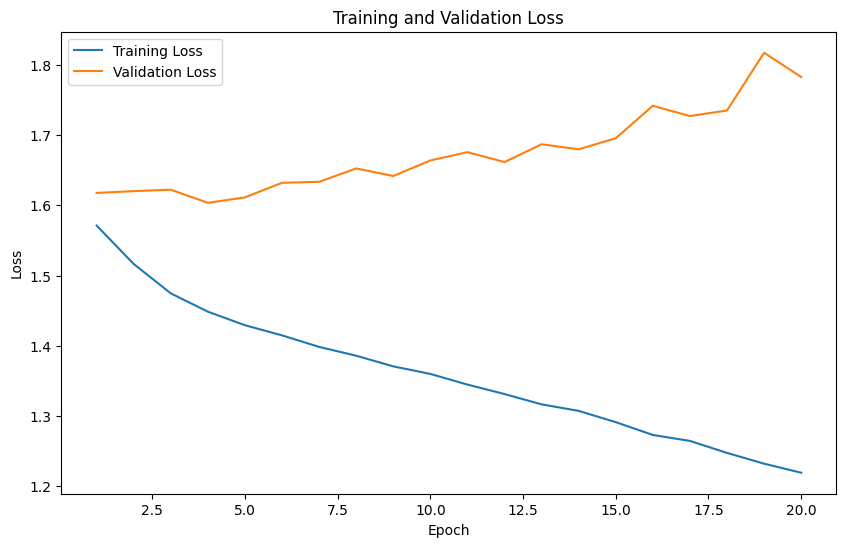

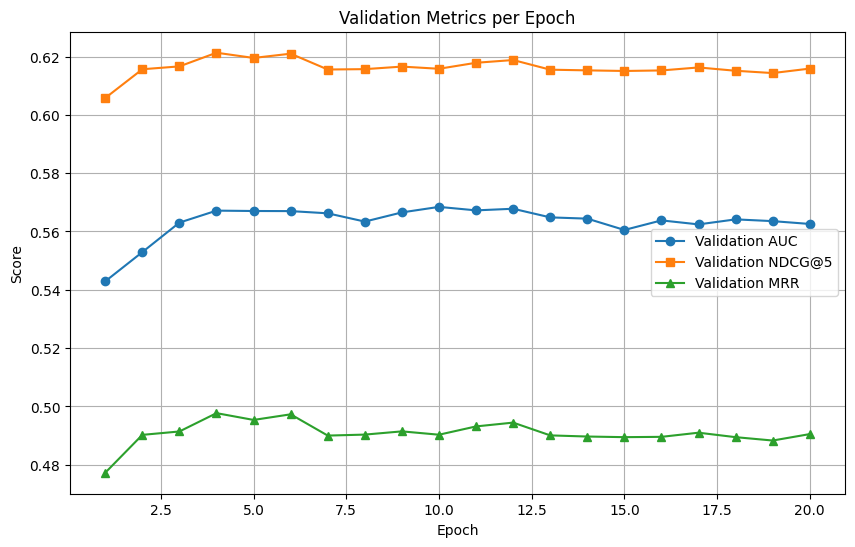

Training and validation complete!


In [31]:
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader
import numpy as np

# Define parameters
NUM_EPOCHS = 20          # Number of epochs
BATCH_SIZE = 64         # Batch size
LEARNING_RATE = 1e-4    # Learning rate
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Split datasets
train_size = int(0.9 * len(train_dataset))
train_val_size = len(train_dataset) - train_size
train_indices = list(range(len(train_dataset)))
train_split, train_val_split = torch.utils.data.random_split(train_dataset, [train_size, train_val_size])

val_size = int(0.2 * len(val_dataset))
test_size = len(val_dataset) - val_size
val_split, test_split = torch.utils.data.random_split(val_dataset, [val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
train_val_loader = DataLoader(train_val_split, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_split, batch_size=BATCH_SIZE, shuffle=False)

# Initialize the model, loss, and optimizer
nrms_model = NRMSModel(vocab_size=VOCAB_SIZE,
                       embedding_dim=EMBEDDING_DIM,
                       num_heads=NUM_HEADS,
                       attention_hidden_dim=ATTENTION_HIDDEN_DIM,
                       max_history_len=50,
                       time_embedding_dim=TIME_FEATURE_DIM).to(DEVICE)

criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(nrms_model.parameters(), lr=LEARNING_RATE)  # Optimizer

# Training Loop
train_losses = []
val_losses = []
val_aucs = []
val_ndcg_scores = []
val_mrr_scores = []

for epoch in range(NUM_EPOCHS):
    nrms_model.train()  # Set model to training mode
    total_loss = 0

    for batch_idx, (candidate_titles, candidate_times, user_his_titles, user_his_times, labels) in enumerate(train_loader):
        # Move data to the appropriate device (GPU/CPU)
        candidate_titles = candidate_titles.to(DEVICE)
        candidate_times = candidate_times.to(DEVICE)
        user_his_titles = user_his_titles.to(DEVICE)
        user_his_times = user_his_times.to(DEVICE)
        labels = torch.argmax(labels, dim=1).to(DEVICE)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        click_scores = nrms_model(candidate_titles, candidate_times, user_his_titles, user_his_times)

        # Compute loss
        loss = criterion(click_scores, labels)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print progress every 10 batches
        if (batch_idx + 1) % 200 == 0:
            print(f"  Epoch [{epoch + 1}/{NUM_EPOCHS}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")


    # Track training loss
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    nrms_model.eval()
    val_loss = 0
    all_labels = []
    all_scores = []
    ndcg_scores = []
    mrr_scores = []

    with torch.no_grad():
        for candidate_titles, candidate_times, user_his_titles, user_his_times, labels in val_loader:
            candidate_titles = candidate_titles.to(DEVICE)
            candidate_times = candidate_times.to(DEVICE)
            user_his_titles = user_his_titles.to(DEVICE)
            user_his_times = user_his_times.to(DEVICE)
            labels = torch.argmax(labels, dim=1).to(DEVICE)

            # Forward pass
            click_scores = nrms_model(candidate_titles, candidate_times, user_his_titles, user_his_times)

            # Compute loss
            loss = criterion(click_scores, labels)
            val_loss += loss.item()

            # Collect predictions for AUC calculation
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(torch.softmax(click_scores, dim=1).cpu().numpy())

            # Compute NDCG@5 and MRR for each batch
            batch_scores = torch.softmax(click_scores, dim=1).cpu().numpy()
            batch_labels = np.eye(batch_scores.shape[1])[labels.cpu().numpy()]  # One-hot encoded labels

            for scores, true_labels in zip(batch_scores, batch_labels):
                ndcg_scores.append(ndcg_at_k(scores, true_labels, k=5))
                mrr_scores.append(mean_reciprocal_rank(scores, true_labels))

    # Track validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Compute AUC
    val_auc = roc_auc_score(all_labels, all_scores, multi_class = 'ovr')
    val_aucs.append(val_auc)

    # NDCG@5 and MRR
    avg_ndcg = np.mean(ndcg_scores)
    avg_mrr = np.mean(mrr_scores)
    val_ndcg_scores.append(avg_ndcg)
    val_mrr_scores.append(avg_mrr)

    # Print metrics for the epoch
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]")
    print(f"  Training Loss: {avg_train_loss:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation AUC: {val_auc:.4f}")
    print(f"  Validation NDCG@5: {avg_ndcg:.4f}")
    print(f"  Validation MRR: {avg_mrr:.4f}")
    print("-" * 40)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label="Training Loss")
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot validation metrics (AUC, NDCG@5, and MRR)
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), val_aucs, label="Validation AUC", marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_ndcg_scores, label="Validation NDCG@5", marker='s')
plt.plot(range(1, NUM_EPOCHS + 1), val_mrr_scores, label="Validation MRR", marker='^')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics per Epoch")
plt.legend()
plt.grid()
plt.show()


print("Training and validation complete!")

In [32]:
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

def test_model(model, test_loader, device):
    """
    Test the model on the test set and compute metrics.

    Args:
        model (nn.Module): Trained model to evaluate.
        test_loader (DataLoader): DataLoader for the test set.
        device (str): Device to run the evaluation on ("cuda" or "cpu").

    Returns:
        Tuple[float, float, float, float]: Accuracy, AUC, NDCG@5, and MRR scores on the test set.
    """
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    all_scores = []
    ndcg_scores = []
    mrr_scores = []

    with torch.no_grad():  # No gradient computation during evaluation
        for batch_idx, (candidate_titles, candidate_times, user_his_titles, user_his_times, labels) in enumerate(test_loader):
            # Move data to the appropriate device
            candidate_titles = candidate_titles.to(device)  # Shape: (batch_size, num_candidates, max_title_len)
            candidate_times = candidate_times.to(device)    # Shape: (batch_size, num_candidates, time_feature_dim)
            user_his_titles = user_his_titles.to(device)    # Shape: (batch_size, max_history_len, max_title_len)
            user_his_times = user_his_times.to(device)      # Shape: (batch_size, max_history_len, time_feature_dim)
            labels = torch.argmax(labels, dim=1).to(device)  # Convert labels to indices, Shape: (batch_size)

            # Forward pass
            click_scores = model(candidate_titles, candidate_times, user_his_titles, user_his_times)  # Shape: (batch_size, num_candidates)

            # Predicted indices (max score per candidate set)
            preds = torch.argmax(click_scores, dim=1).cpu().numpy()  # Shape: (batch_size)

            # Append true labels and predictions for metrics
            all_labels.extend(labels.cpu().numpy())  # True labels
            all_preds.extend(preds)  # Predicted labels
            batch_scores = torch.softmax(click_scores, dim=1).cpu().numpy()  # Softmax probabilities
            all_scores.extend(batch_scores)

            # Compute NDCG@5 and MRR for each batch
            batch_labels = np.eye(batch_scores.shape[1])[labels.cpu().numpy()]  # One-hot encoded labels
            for scores, true_labels in zip(batch_scores, batch_labels):
                ndcg_scores.append(ndcg_at_k(scores, true_labels, k=5))
                mrr_scores.append(mean_reciprocal_rank(scores, true_labels))

    # Compute overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_scores, multi_class="ovr")  # Use full softmax scores
    avg_ndcg = np.mean(ndcg_scores)
    avg_mrr = np.mean(mrr_scores)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test AUC: {auc:.4f}")
    print(f"Test NDCG@5: {avg_ndcg:.4f}")
    print(f"Test MRR: {avg_mrr:.4f}")

    return accuracy, auc, avg_ndcg, avg_mrr

In [33]:
# Test the trained model
test_model(nrms_model, test_loader, DEVICE)


Test Accuracy: 0.2302
Test AUC: 0.5604
Test NDCG@5: 0.6146
Test MRR: 0.4887


(0.23019996079200156,
 0.5604333806328858,
 0.6146319375646307,
 0.4887089132849768)

In [34]:
torch.save(nrms_model.state_dict(), "/content/drive/MyDrive/DTU/Kandidat/Semester 9/Deep learning/Final project/Data/content/nrms_model.pth")

In [ ]:
nrms_model = NRMSModel(vocab_size=VOCAB_SIZE,
                       embedding_dim=EMBEDDING_DIM,
                       num_heads=NUM_HEADS,
                       attention_hidden_dim=ATTENTION_HIDDEN_DIM,
                       max_history_len=50).to(DEVICE)
nrms_model.load_state_dict(torch.load("/content/nrms_model.pth"))
nrms_model.eval()  # Set model to evaluation mode


In [ ]:
# Inspect click probabilities
for batch_idx, (candidate_titles, user_his_titles, labels) in enumerate(val_loader):
    candidate_titles = candidate_titles.to(DEVICE)
    user_his_titles = user_his_titles.to(DEVICE)
    labels = torch.argmax(labels, dim=1).to(DEVICE)

    # Forward pass
    click_scores = nrms_model(candidate_titles, user_his_titles)
    softmax_probs = torch.softmax(click_scores, dim=1)

    for i in range(candidate_titles.size(0)):  # Iterate over the batch
        print(f"\nUser {i + 1}:")
        print(f"True Label: {labels[i].item()}")
        print(f"Predicted Click Probabilities: {softmax_probs[i].cpu().detach().numpy()}")
    break  # Remove this to inspect the full dataset
